# Matching algorithms

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd

%matplotlib inline

## Unweighted bipartite mapping

One such problem is mapping students and dorm rooms. In this problem, students give a list of rooms they are willing to stay in. Each student should be matched to one room.

In [2]:
edgelist_df = pd.DataFrame({"node1": list("AABBCCDD"), "node2": list("12233441")})
edgelist_df

,node1,node2
0,A,1
1,A,2
2,B,2
3,B,3
4,C,3
5,C,4
6,D,4
7,D,1


In [3]:
G = nx.from_pandas_edgelist(edgelist_df, source="node1", target="node2")
nx.is_directed(G)

False

In [4]:
left, right = nx.bipartite.sets(G)
left, right

({'A', 'B', 'C', 'D'}, {'1', '2', '3', '4'})

In [5]:
# Update position for node from each group.
for i, node in enumerate(sorted(list(left))):
    G.add_node(node, pos=(0, i))

for i, node in enumerate(sorted(list(right))):
    G.add_node(node, pos=(1, i))

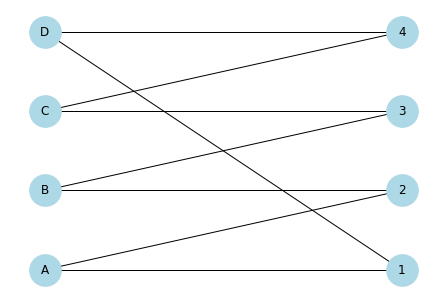

In [6]:
nx.draw(
    G,
    pos=nx.get_node_attributes(G, "pos"),
    with_labels=True,
    node_color="lightblue",
    node_size=1_000,
)

In [7]:
matches = nx.algorithms.bipartite.matching.hopcroft_karp_matching(
    G, top_nodes=list(set(edgelist_df.node1))
)
matches

{'B': '2',
 'A': '1',
 'C': '3',
 'D': '4',
 '3': 'C',
 '1': 'A',
 '4': 'D',
 '2': 'B'}

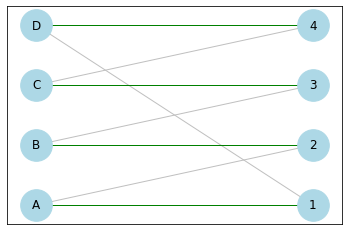

In [8]:
nx.draw_networkx_nodes(
    G,
    pos=nx.get_node_attributes(G, "pos"),
    node_color="lightblue",
    node_size=1_000,
)
nx.draw_networkx_labels(
    G,
    pos=nx.get_node_attributes(G, "pos"),
)
nx.draw_networkx_edges(
    G,
    pos=nx.get_node_attributes(G, "pos"),
    edge_color=["g" if edge in matches.items() else "silver" for edge in G.edges],
)

# Weighted bipartite matching

In the previous problem, we tried to find a perfect matching in an unweighted graph. What if every graph has a certain weight attached to it? The weights could be quality index (for student-dorm matching) or valuation in markets etc.

In [9]:
sellers = ["A", "B", "C"]
buyers = ["x", "y", "z"]
valuations_for_buyers = [[12, 4, 2], [8, 7, 6], [7, 5, 2]]
sellers_price = [0, 0, 0]

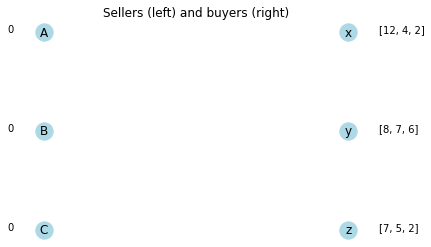

In [10]:
G = nx.Graph()

# Update position for node from each group
for i, node in enumerate(sellers):
    G.add_node(node, pos=(0, len(sellers) - i))
for i, node in enumerate(buyers):
    G.add_node(node, pos=(1, len(buyers) - i))

# Plot text for buyers.
for i, buyer in enumerate(buyers):
    plt.text(
        1.1, len(buyers) - i, s=valuations_for_buyers[i], horizontalalignment="left"
    )

# Plot text for sellers.
for i, seller in enumerate(sellers):
    plt.text(-0.1, len(sellers) - i, s=sellers_price[i], horizontalalignment="right")

plt.title("Sellers (left) and buyers (right)")
nx.draw(
    G, pos=nx.get_node_attributes(G, "pos"), with_labels=True, node_color="lightblue"
)

What we want to achieve is clearing of market. Clearing happens when all houses are sold to one buyer, and every buyer bought one house. This can be done using the auction algorithm:

1. Sellers quote price
2. Buyers calculate utility: Net valuation (payoff) = Gross valuation - Price charged by seller
3. Buyers select the object that has the highest payoff
4. If the market is not cleared, the sellers who have more than one offer (overdetermined) will increase the price by one unit, and the process is repeated.

In [11]:
# function to pick supplier with the maximum utility
def match_to_maximum_utility(sellers, buyers, valuation, price):
    max_utility_sellers = {}
    for buyer_index in range(len(buyers)):
        max_utility = 0

        for seller_index in range(len(sellers)):
            if max_utility < valuation[buyer_index][seller_index] - price[seller_index]:
                max_utility = valuation[buyer_index][seller_index] - price[seller_index]
                max_utility_sellers[buyers[buyer_index]] = [sellers[seller_index]]
            elif (
                max_utility
                == valuation[buyer_index][seller_index] - price[seller_index]
            ):
                max_utility_sellers[buyers[buyer_index]].append(sellers[seller_index])

    return max_utility_sellers

In [12]:
max_util = match_to_maximum_utility(
    sellers, buyers, valuations_for_buyers, sellers_price
)
max_util

{'x': ['A'], 'y': ['A'], 'z': ['A']}

Assuming the initial price set by the seller is zero, buyer x calculates the following utility:

- For A: 12 - 0 = 12
- For B: 4 - 0 = 4
- For C: 2 - 0 = 2

As the utility of A is the highest, x will choose A. Similarly y and z will also choose A

In [13]:
def plot_max_utility_graph(
    sellers, buyers, valuations_for_buyers, sellers_price, max_util
):
    G = nx.Graph()
    pos = {}

    # Update position for node from each group
    for i, node in enumerate(sellers):
        G.add_node(node, pos=(0, len(sellers) - i))
    for i, node in enumerate(buyers):
        G.add_node(node, pos=(1, len(buyers) - i))

    # Make edges
    for key, values in max_util.items():
        for value in values:
            G.add_edge(key, value)

    # Plot text for buyers.
    for i, buyer in enumerate(buyers):
        plt.text(
            1.1, len(buyers) - i, s=valuations_for_buyers[i], horizontalalignment="left"
        )

    # Plot text for sellers.
    for i, seller in enumerate(sellers):
        plt.text(
            -0.1, len(sellers) - i, s=sellers_price[i], horizontalalignment="right"
        )

    nx.draw(
        G,
        pos=nx.get_node_attributes(G, "pos"),
        with_labels=True,
        node_color="lightblue",
    )
    plt.show()

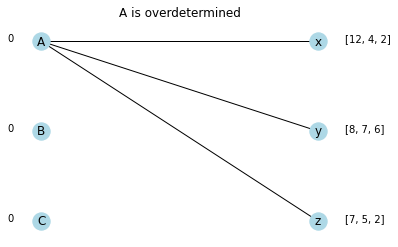

In [14]:
plt.title("A is overdetermined")
plot_max_utility_graph(sellers, buyers, valuations_for_buyers, sellers_price, max_util)

For the overdetermined edge A, we increase the price by one unit

In [15]:
from collections import Counter


def get_overdetermined_edge_and_increase_price(sellers, sellers_price, max_util):
    counts = dict(Counter(sum(max_util.values(), [])))
    over_determined_list = []

    for key, value in counts.items():
        if value > 1:
            over_determined_list.append(key)
            sellers_price[sellers.index(key)] += 1
    print(
        "Nodes",
        over_determined_list,
        "are over determined. Added 1 to the prize for the suppliers",
    )
    return counts

In [16]:
get_overdetermined_edge_and_increase_price(sellers, sellers_price, max_util)

Nodes ['A'] are over determined. Added 1 to the prize for the suppliers


{'A': 3}

We will continue this process until the market is cleared

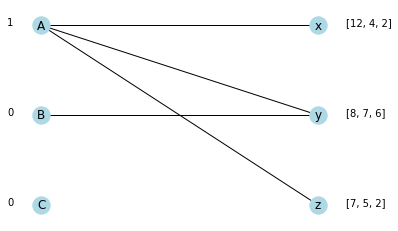

Nodes ['A'] are over determined. Added 1 to the prize for the suppliers


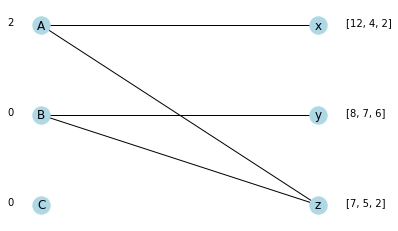

Nodes ['A', 'B'] are over determined. Added 1 to the prize for the suppliers


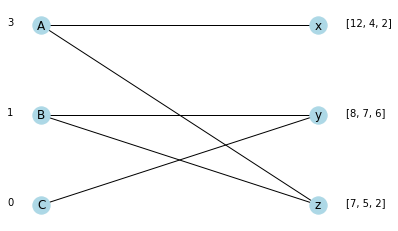

Nodes ['A', 'B'] are over determined. Added 1 to the prize for the suppliers


In [18]:
no_of_sellers_selected = 0

while no_of_sellers_selected != len(sellers):
    max_util = match_to_maximum_utility(
        sellers, buyers, valuations_for_buyers, sellers_price
    )
    plot_max_utility_graph(
        sellers, buyers, valuations_for_buyers, sellers_price, max_util
    )
    counts = get_overdetermined_edge_and_increase_price(
        sellers, sellers_price, max_util
    )
    no_of_sellers_selected = len(counts)

We can see that the costs (A:3, B:1, C: 0), the market can be cleared with buyer x choosing A, y choosing C and z choosing B. This is the maximum weight perfect matching.

In [41]:
from ortools.sat.python import cp_model

model = cp_model.CpModel()

In [42]:
buyer_bool_vars = {}
for bi in range(len(buyers)):
    buyer = buyers[bi]
    for si in range(len(sellers)):
        seller = sellers[si]
        buyer_bool_vars[bi, si] = model.NewBoolVar("buyer_%s_%s" % (buyer, seller))
        print("Add buyer seller", buyer_bool_vars[bi, si])

# Add constraint - each buyer can only have one seller.
for bi in range(len(buyers)):
    model.Add(sum(buyer_bool_vars[bi, si] for si in range(len(sellers))) == 1)

# Add constraint - each seller can only have one buyer
for si in range(len(sellers)):
    model.Add(sum(buyer_bool_vars[bi, si] for bi in range(len(buyers))) == 1)

# Costs to optimize.
costs = model.NewIntVar(0, 1000, "costs")
model.Add(
    sum(
        valuations_for_buyers[bi][si] * buyer_bool_vars[bi, si]
        for bi in range(len(buyers))
        for si in range(len(sellers))
    )
    == costs
)

Add buyer seller buyer_x_A
Add buyer seller buyer_x_B
Add buyer seller buyer_x_C
Add buyer seller buyer_y_A
Add buyer seller buyer_y_B
Add buyer seller buyer_y_C
Add buyer seller buyer_z_A
Add buyer seller buyer_z_B
Add buyer seller buyer_z_C


In [43]:
# Objective is to maximize cost
model.Maximize(costs)

In [44]:
# Solving the problem
solver = cp_model.CpSolver()
solution_printer = cp_model.ObjectiveSolutionPrinter()
status = solver.SolveWithSolutionCallback(model, solution_printer)

Solution 0, time = 0.00 s, objective = 16
Solution 1, time = 0.00 s, objective = 17
Solution 2, time = 0.00 s, objective = 23


In [45]:
status == cp_model.OPTIMAL

True

In [46]:
for bi in range(len(buyers)):
    for si in range(len(sellers)):
        print(buyers[bi], sellers[si], solver.Value(buyer_bool_vars[bi, si]))
solver.Value(costs)

x A 1
x B 0
x C 0
y A 0
y B 0
y C 1
z A 0
z B 1
z C 0


23